In [1]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 6 - MCQ Long answer HTML tags

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- system prompt: MCQ_system_prompt_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [2]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


gt_df = pd.DataFrame(ground_truth, dtype='string')
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [3]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/responses_llama3.2_20250210_20:17:23.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,<Reasoning> To determine which object was tidi...
Interaction_T1_14,<Reasoning> To determine which object was tidi...
Interaction_T1_31,Error while generating the response. Look at t...
Interaction_T1_32,<Reasoning> To determine which object was put ...
Interaction_T1_40,<Reasoning> The question asks which object was...
...,...
Feasibility_T6_1453,<Reasoning> To determine what the person is ab...
Feasibility_T6_1454,"<Reasoning> To answer this question, we need t..."
Feasibility_T6_1455,"<Reasoning> To answer this question, we need t..."


In [4]:
predictions_df.iloc[0:20]['answer'].apply(print)


<Reasoning>
To determine which object was tidied up by the person, we need to analyze the sequence of events unfolding in the frames. 

The first two Scene-Graphs show the person standing next to the clothes and then in front of the clothes. This suggests that the person is picking up or arranging the clothes.

In the subsequent Scene-Graphs, the person's relationship with the blanket changes from being on the side to being in front of it. However, this does not necessarily imply that the person is tidying up the blanket, as the person may be holding or touching it instead.

The key insight comes from the later Scene-Graphs, where the person is shown holding the clothes and then being in front of them again. This suggests a reversal of roles, with the person now holding the clothes rather than picking them up.

Therefore, based on this analysis, we can conclude that the object tidied up by the person is actually the clothes.
</Reasoning>

<Final answer>
A: 2. The clothes.
</Final answe

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

In [5]:
# Check if the the template is somewhere in the answer
html_tags_pattern = r'<Final answer>\n+A:\s*\d\.\s*((?:\w+(?:\s|\/)?){,10}\.)\n+<\/Final answer>'
html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


print(f"Answer following the template: {html_tags_mask.value_counts()[True]}\n"
      f"{html_tags_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {html_tags_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 2100
29.59% of the total

Only 4998 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_144570/1550871703.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


Let's start by viewing how many answers follow the template:

In [6]:
# Check if the the template is somewhere in the answer
ans_regex_pattern = r'A:\s+(?:\d\.\s+)((?:\w+(?:\s|\/)?){,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6828
96.20% of the total

Only 270 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_144570/2793212194.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


In [7]:
# Check that contains answer is subset of html_tags
assert (html_tags_mask & contains_answer).sum() == html_tags_mask.sum()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [8]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
Interaction_T1_43,The clothes.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Wipe the table.
Feasibility_T6_1455,Take the shoe.


In [9]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 474 unique answers


In [10]:
ans_df['text'].value_counts()


Took.                     344
Put down.                 329
Tidied up.                273
The towel.                265
The clothes.              258
                         ... 
Close the book.             1
Hold the picture.           1
Lie on the box.             1
Hold the refrigerator.      1
Wipe the table.             1
Name: text, Length: 237, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

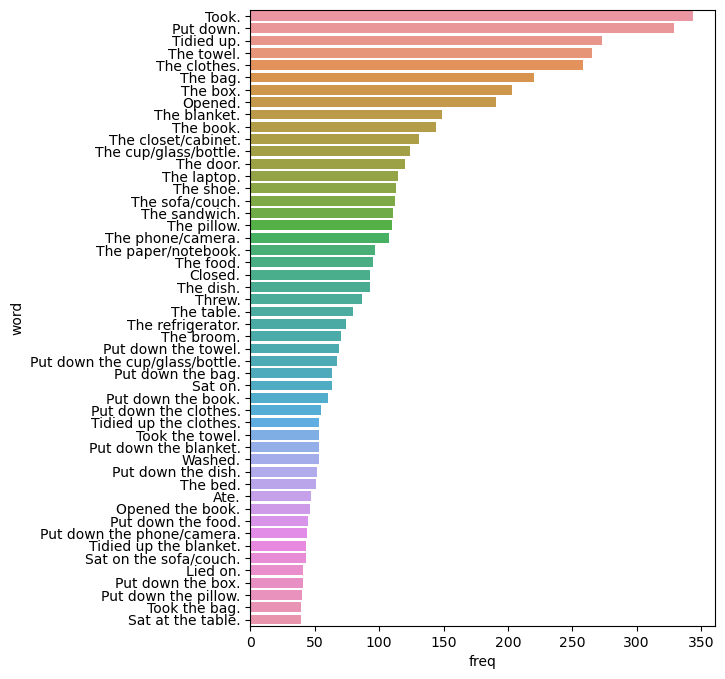

In [11]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [12]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


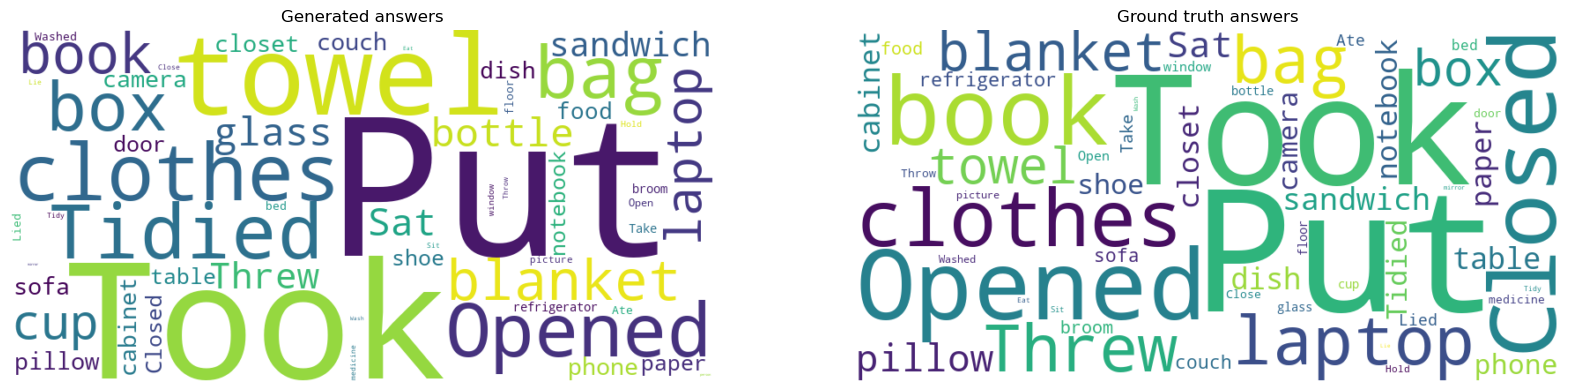

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

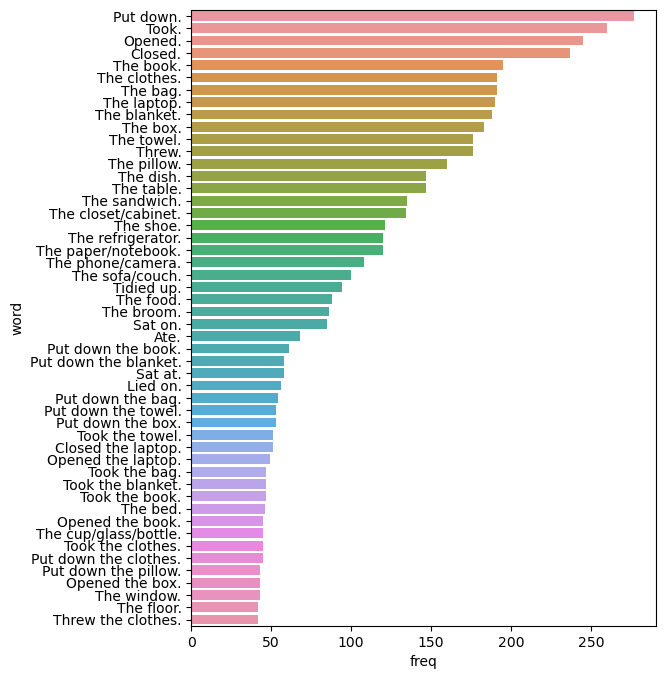

In [14]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [15]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6828, 4)

In [16]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [17]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 44.46%


In [18]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text
id,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.
Interaction_T1_43,"{'0': 'The box.', '1': 'The pillow.', '2': 'Th...",3,The clothes.,The clothes.
Interaction_T1_81,"{'0': 'The bed.', '1': 'The sofa/couch.', '2':...",1,The sofa/couch.,The sofa/couch.
...,...,...,...,...
Feasibility_T6_1428,"{'0': 'Close the refrigerator.', '1': 'Throw t...",3,Take the cup/glass/bottle.,Take the cup/glass/bottle.
Feasibility_T6_1448,"{'0': 'Put down the laptop.', '1': 'Tidy up th...",0,Put down the laptop.,Put down the laptop.
Feasibility_T6_1449,"{'0': 'Throw the towel.', '1': 'Close the refr...",2,Put down the laptop.,Put down the laptop.


check if the equality with NA result in a false or is skipped

In [19]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 42.77%


In [20]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [21]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2285        44.42%  
Sequence            3440        44.85%  
Prediction           619        42.81%  
Feasibility          484        44.01%  


In [22]:
(html_tags_mask & contains_answer).sum()


2100

In [23]:
index_intersect = predictions_df[html_tags_mask].index.intersection(eval_df.index)
print_acc(eval_df.loc[index_intersect], accuracy)


Question type       Total      Accuracy 

Interaction          586        47.44%  
Sequence            1068        48.03%  
Prediction           258        44.19%  
Feasibility          188        46.81%  
